In [10]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('../mnist_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../mnist_data/american_sign_language.PNG
../mnist_data/sign_mnist_test.csv
../mnist_data/sign_mnist_train.csv
../mnist_data/amer_sign3.png
../mnist_data/amer_sign2.png
../mnist_data/sign_mnist_train/sign_mnist_train.csv
../mnist_data/sign_mnist_test/sign_mnist_test.csv


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau

### Loading the ASL dataset

In [12]:
train_df = pd.read_csv('../mnist_data/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('../mnist_data/sign_mnist_test/sign_mnist_test.csv')

In [13]:
y = test_df['label']

In [14]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Data Visualization and Preprocessing

In [16]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [17]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [18]:
x_train = train_df.values
x_test = test_df.values

In [19]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [20]:
# Reshape the data from 1D to 3D for CNN
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

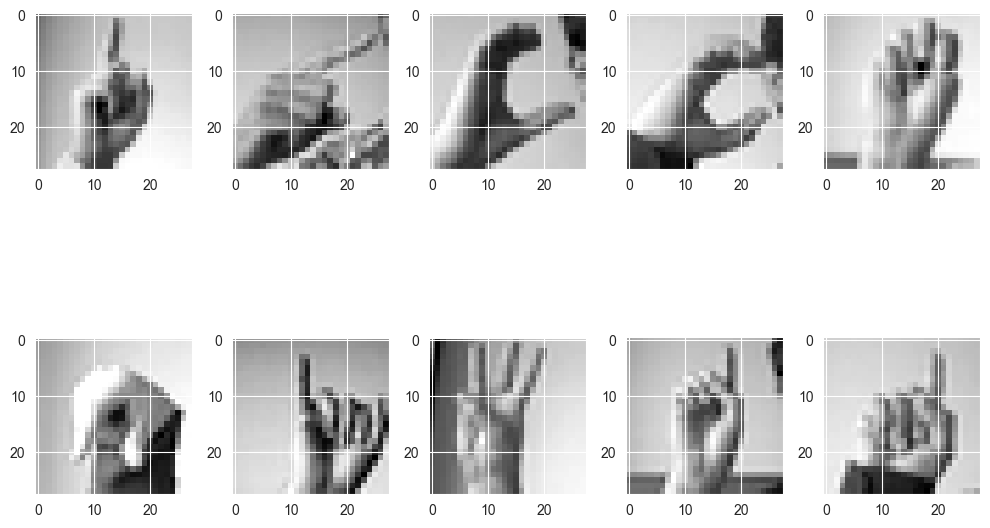

In [21]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10,10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(x_train[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()

### Data Augmentation

In [22]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)
datagen.fit(x_train)

### Training the Model

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [24]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

/Users/nathanvandrie/Documents/signed/ml-service/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [25]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[learning_rate_reduction]
)

Epoch 1/20


/Users/nathanvandrie/Documents/signed/ml-service/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.4560 - loss: 1.8600 - val_accuracy: 0.1755 - val_loss: 3.4888 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9110 - loss: 0.2718 - val_accuracy: 0.5567 - val_loss: 1.3896 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9608 - loss: 0.1203 - val_accuracy: 0.9297 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9763 - loss: 0.0747 - val_accuracy: 0.9833 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9845 - loss: 0.0479 - val_accuracy: 0.8903 - val_loss: 0.3541 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9871 - loss: 0.0396 - val_accuracy: 0.9852 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9900 - loss: 0.0315

In [26]:
print("Accuracy: ", model.evaluate(x_test, y_test)[1]*100, "%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 7.0776e-04
Accuracy:  99.98605847358704 %


### Analysis

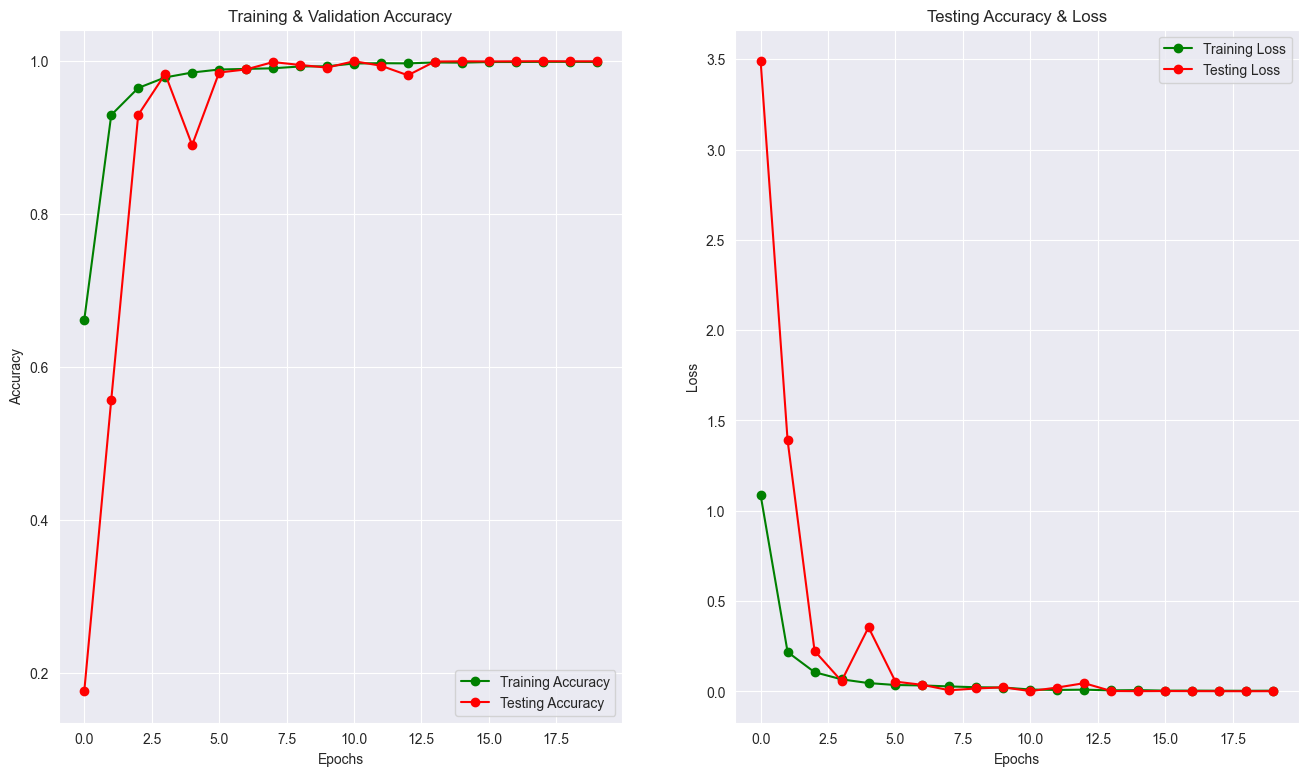

In [27]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [31]:
predictions = np.argmax(model.predict(x_test),axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([ 6,  5, 10,  0,  3])

In [32]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [33]:
cm = confusion_matrix(y, predictions)

In [34]:
cm = pd.DataFrame(
    cm,
    index = [i for i in range(25) if i != 9],
    columns = [i for i in range(25) if i != 9])

<Axes: >

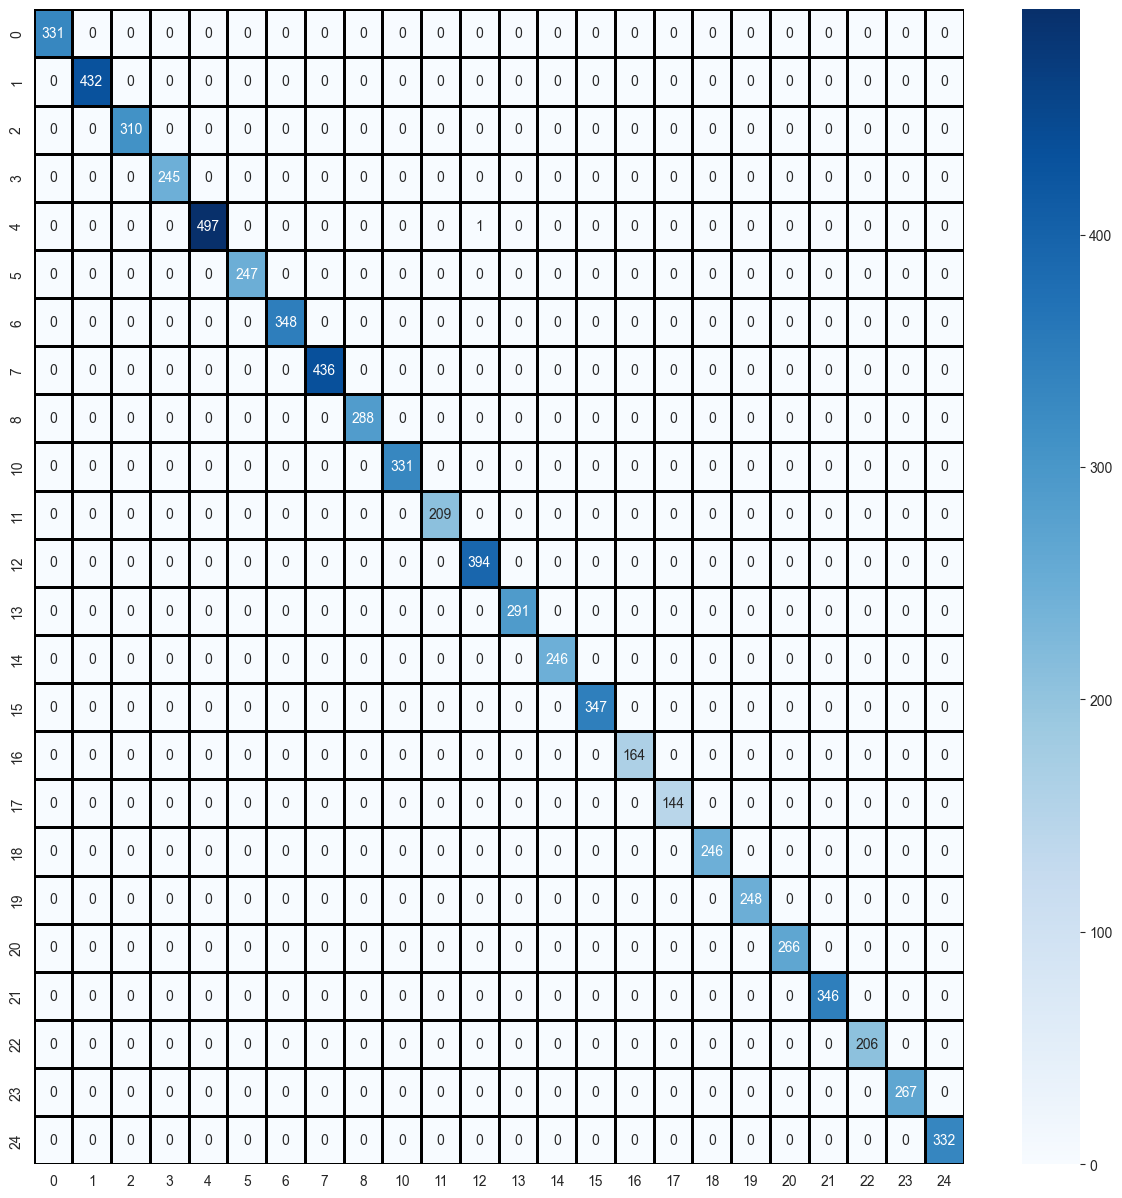

In [35]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [36]:
correct = np.nonzero(predictions == y)[0]

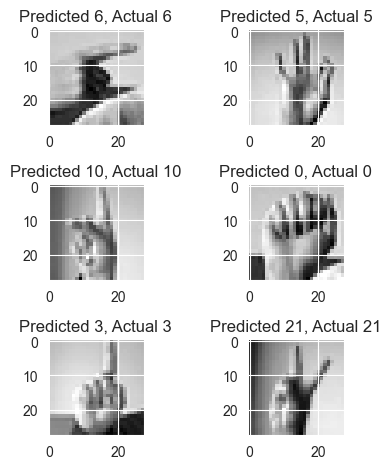

In [41]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

### Saving the Model

In [42]:
model.save('sign_language_model.keras')